In [1]:
%load_ext autoreload
%autoreload 2

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from stljax.formula import *
from stljax.viz import *
from stljax.utils import smooth_mask, anneal

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

jax.config.update("jax_enable_x64", True)


Some helper functions

In [6]:

@jax.jit
def dynamics_discrete_step(state, control, dt=0.1):
    '''Single integrator dynamics'''
    return state + control * dt

@jax.jit
def simulate_dynamics(controls, state0, dt):
    T = controls.shape[0]
    _states = [state0]
    for t in range(T):
        _states.append(dynamics_discrete_step(_states[-1], controls[t,:], dt))
    return jnp.concatenate(_states, 0)

@jax.jit
def compute_distance_to_point(states, point):
    return jnp.linalg.norm(states[...,:2] - point, axis=-1, keepdims=True)

@jax.jit
def compute_distance_to_origin(states):
    return compute_distance_to_point(states, jnp.zeros(2))


Start setting STL formulas

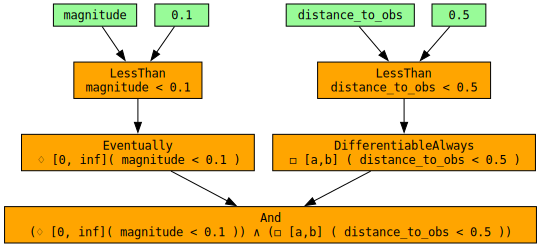

In [15]:
# environment parameters
obstacle_center = jnp.array([[0,2]]) # obstacle location
reach_radius = 0.1
obstacle_radius = 0.5


distance_to_origin = Predicate("magnitude", compute_distance_to_origin)
distance_to_obstacle = Predicate("distance_to_obs", lambda x: compute_distance_to_point(x, obstacle_center))

reach = Eventually(distance_to_origin < reach_radius)
avoid = Always(distance_to_obstacle > obstacle_radius)
# stay = Eventually(Always(distance_to_obstacle < 0.5, interval=[0, 7]), interval=[0,20])   # if you don't want to have differentiable time intervals
stay = DifferentiableAlways(distance_to_obstacle < 0.5)

formula = reach & stay
# formula = Until(distance_to_obstacle > 0.5, Always(distance_to_origin < 0.5), interval=[40,45])

make_stl_graph(formula)


Defining cost function

In [20]:

def exponenial_penalty(x):
    return jnp.exp(x)

@functools.partial(jax.jit, static_argnames=("approx_method"))
def loss(controls, t_start, t_end, scale, state0, umax, dt, coeffs=[1., 0.1, 5., 0.], approx_method="true", temperature=None):
    # see paper for more details on loss function
    # generate trajectory from control sequence and reverse along time dimension
    traj = simulate_dynamics(controls, state0, dt)
    # loss functions
    loss_robustness = jax.nn.relu(-formula.robustness(traj, t_start=t_start, t_end=t_end, scale=scale, approx_method=approx_method, temperature=temperature))
    loss_control_smoothness = 0 * jnp.abs(jnp.diff(controls, axis=1)).sum(-1).mean()  + (controls**2).sum(-1).mean() # make controls smoother
    loss_control_limits = jax.nn.relu(jnp.linalg.norm(controls, axis=-1) - umax).mean()   # penalize control limit violation
    min_interval = 0.2
    interval_difference = min_interval - (t_end - t_start)  # negative is good
    cost_array = jnp.array([
        loss_robustness,
        loss_control_smoothness,
        loss_control_limits,
        exponenial_penalty(2 * interval_difference)
    ])
    return jnp.dot(jnp.array(coeffs), cost_array)
    # return coeffs[0] * loss_robustness + coeffs[1] * loss_control_smoothness + coeffs[2] * loss_control_limits + coeffs[3] * exponenial_penalty(2 * interval_difference)
    
grad_jit = jax.jit(jax.grad(loss, [0,1,2]), static_argnames="approx_method")

@jax.jit
def true_robustness(controls, t_start, t_end, scale, state0, dt):
    traj = simulate_dynamics(controls, state0, dt)
    return formula.robustness(traj, t_start=t_start, t_end=t_end, scale=scale).mean()

@jax.jit
def schedule(i, i_max, start, end):
    j = (i / i_max)
    temp = anneal(j)
    return temp * (end - start) + start


Setting up parameters to begin the gradient descent routine

In [21]:
np.random.seed(123)
T = 51  # time horizon
dt = 0.1 # time step size
ts = jnp.array([t * dt for t in range(T)]) # time step array
umax = 2.  # max control limit

controls = jnp.array(np.random.randn(T,2))  # initial random control sequence
state0 = jnp.ones(2).reshape([1,2]) * 3. # initial state
states_ = [simulate_dynamics(controls, state0, dt)]  # list to collect all the state trajectories at each gradient descent step

# initial values for time interval (before passing through softmax)
t_start = -1.8
t_end = 1.5

lr = 1E-2 # learning rate
approx_method = "logsumexp"
n_steps = 10000   # number of gradient steps

# start and end values for annealing temperature and scale
start_temp = 1
end_temp = 100

start_scale = 10
end_scale = 100

coeffs = [1.1, 0.5, 2., 0.05] # coefficients for loss function

Run the functions to test them out


In [ ]:

scale = 0.1
loss(controls, t_start, t_end, scale, state0, umax, dt)
loss(controls, t_start, t_end, scale, state0, umax, dt, approx_method="softmax", temperature=5)
true_robustness(controls, t_start, t_end, scale, state0, dt)
grad_jit(controls, t_start, t_end, scale, state0, umax, dt, coeffs, approx_method, 0.2);



Run optimization loop!

In [24]:

for i in range(n_steps):
    temperature = schedule(i, n_steps, start_temp, end_temp)
    scale = schedule(i, n_steps, start_scale, end_scale)
    
    t_start_ = jax.nn.sigmoid(t_start)
    t_end_ = jax.nn.sigmoid(t_end)
    g1, g2, g3 = grad_jit(controls, t_start_, t_end_, scale, state0, umax, dt, coeffs, approx_method, temperature)  # take gradient
    if ((jnp.linalg.norm(g1)/ T / 2) < 5E-6) or (jnp.isnan(g1).sum() > 0):
        break
    # g =  jax.grad(loss, 0)(controls, state0, umax, approx_method, temperature)  # not jitting
    controls -= g1 * lr
    t_start -= g2 * lr * t_start_ * (1 - t_start_) 
    t_end -= g3 * lr * t_end_ * (1 - t_end_)
    # print(g2, g3, g3 * lr * t_end_ * (1 - t_end_))
    
    states_.append(simulate_dynamics(controls, state0, dt))
    if (i % 50) == 0:
        t_start_ = jax.nn.sigmoid(t_start)
        t_end_ = jax.nn.sigmoid(t_end)
        print("%3i -- true robustness: %.2f   smoothness: %.2f    control limits: %.2f    interval: %.2f t_start: %.2f    t_end: %.2f"%(i, true_robustness(controls, t_start_, t_end_, 1000., state0, dt), loss(controls, t_start_, t_end_, 1000., state0, umax, dt, coeffs=[0., 1., 0., 0.]), loss(controls, t_start_, t_end_, 1000., state0, umax, dt, coeffs=[0., 0., 1., 0.]), loss(controls, t_start_, t_end_, 1000., state0, umax, dt, coeffs=[0., 0., 0., 1.]), t_start_, t_end_))


  0 -- true robustness: -3.73   smoothness: 2.58    control limits: 0.07    interval: 0.39 t_start: 0.14    t_end: 0.82
 50 -- true robustness: -3.64   smoothness: 2.51    control limits: 0.07    interval: 0.40 t_start: 0.14    t_end: 0.80
100 -- true robustness: -3.56   smoothness: 2.45    control limits: 0.06    interval: 0.40 t_start: 0.14    t_end: 0.80
150 -- true robustness: -3.48   smoothness: 2.39    control limits: 0.05    interval: 0.40 t_start: 0.14    t_end: 0.80
200 -- true robustness: -3.40   smoothness: 2.34    control limits: 0.05    interval: 0.41 t_start: 0.15    t_end: 0.80
250 -- true robustness: -3.32   smoothness: 2.29    control limits: 0.04    interval: 0.43 t_start: 0.16    t_end: 0.78
300 -- true robustness: -3.25   smoothness: 2.24    control limits: 0.04    interval: 0.43 t_start: 0.16    t_end: 0.78
350 -- true robustness: -3.17   smoothness: 2.20    control limits: 0.03    interval: 0.43 t_start: 0.16    t_end: 0.78
400 -- true robustness: -3.10   smoothne

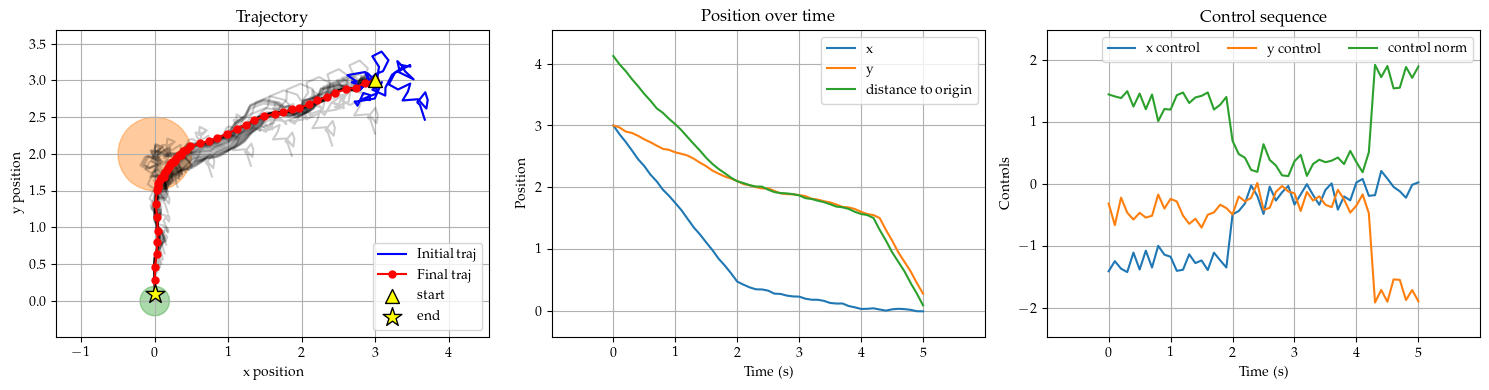

In [59]:
fig, axs = plt.subplots(1,3, figsize=(15,4)) 

ax = axs[0]
circle1 = plt.Circle((0, 0), 0.2, color='C2', alpha=0.4)
circle2 = plt.Circle(obstacle_center[0], 0.5, color='C1', alpha=0.4)

ax.add_patch(circle1)
ax.add_patch(circle2)

N = 250
[ax.plot(*s.T, color="k", alpha=0.2) for s in states_[::N]]
[ax.plot(*s.T, color="blue", label="Initial traj") for s in states_[:1]]
[ax.plot(*s.T, '.-', color="r", markersize=10, label="Final traj") for s in states_[-1:]]

ax.scatter(states_[-1][0,:1], states_[-1][0,1:], marker="^", c='yellow', edgecolor="k", s=100, label="start", zorder=4)
ax.scatter(states_[-1][-1,:1], states_[-1][-1,1:], marker="*", c='yellow', edgecolor="k", s=200, label="end", zorder=4)

ax.set_xlabel("x position")
ax.set_ylabel("y position")
ax.grid()
ax.legend()
ax.axis("equal")
ax.set_title("Trajectory")

# plot x, y
ax = axs[1]
ax.plot(ts, states_[-1][:-1,:1], label="x")
ax.plot(ts, states_[-1][:-1,1:], label="y")
ax.plot(ts, distance_to_origin.predicate_function(states_[-1][1:]).squeeze(), label="distance to origin")
ax.grid()
ax.axis("equal")
ax.legend()
ax.set_xlabel("Time (s)")
ax.set_ylabel("Position")
ax.set_title("Position over time")



# plot control signal
ax = axs[2]
ax.plot(ts, controls[:,:1], label="x control")
ax.plot(ts, controls[:,1:], label="y control")
ax.plot(ts, jnp.linalg.norm(controls, axis=-1).squeeze(), label="control norm")
ax.grid()
ax.axis("equal")
ax.legend(ncols=3)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Controls")
ax.set_title("Control sequence")



plt.tight_layout()


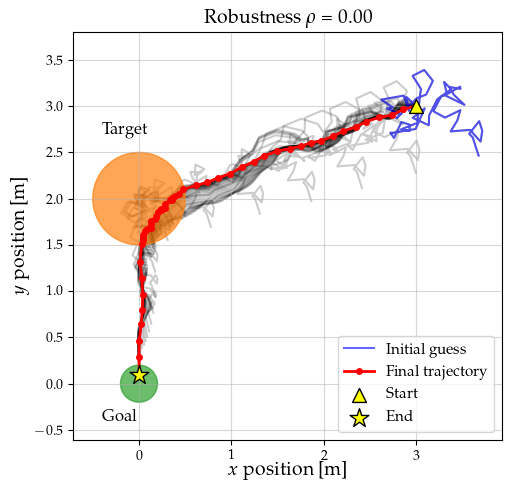

In [60]:
fontsize = 14
fig, ax = plt.subplots(figsize=(5, 5)) # note we must use plt.subplots, not plt.subplot

circle1 = plt.Circle((0, 0), 0.2, color='C2', alpha=0.7)
circle2 = plt.Circle(obstacle_center[0], 0.5, color='C1', alpha=0.7)

N = 250 # show intermediate solutions at everge N iterations

[ax.plot(*s.T, color="blue", label="Initial traj", alpha=0.6) for s in states_[:1]]
[ax.plot(*s.T, '.-', color="r", label="Final traj", zorder=10, linewidth=2, markersize=8) for s in states_[-1:]]
ax.scatter(states_[-1][0,:1], states_[-1][0,1:], zorder=10, label="start", color="yellow", edgecolor="black", marker="^", s=100)
ax.scatter(states_[-1][-1,:1], states_[-1][-1,1:], zorder=10, label="end", color="yellow", edgecolor="black", marker="*", s=200)
[ax.plot(*s.T, color="k", alpha=0.2, label="Iterations", zorder=0) for s in states_[::N]]

ax.add_patch(circle1)
ax.add_patch(circle2)

ax.annotate("Goal", (-0.4, -0.4), fontsize=fontsize-2)
ax.annotate("Target", (-0.4, 2.7), fontsize=fontsize-2)

ax.set_xlabel("$x$ position [m]", fontsize=fontsize, labelpad=-2)
ax.set_ylabel("$y$ position [m]", fontsize=fontsize)
ax.set_title("Robustness $\\rho$ = %.2f"%formula.robustness(states_[-1], t_start=jax.nn.sigmoid(t_start), t_end=jax.nn.sigmoid(t_end), scale=1000.), fontsize=fontsize)
ax.grid(zorder=-6, alpha=0.5)
ax.legend(["Initial guess", "Final trajectory", "Start", "End"], ncol=1, fontsize=fontsize-3)
ax.axis("equal")
plt.tight_layout()
# plt.savefig("figs/trajectory_optimization_diff_time_small.png", dpi=200, transparent=True)
